In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
import torch
import numpy as np

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import abbyy_course_cvdl_t2

In [4]:
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [5]:
import abbyy_course_cvdl_t2
TINY_COCO_BASE = Path(abbyy_course_cvdl_t2.__file__).parent.parent / 'data'
TINY_COCO_BASE.exists()

True

In [6]:
from torchvision.datasets import CocoDetection

Если CocoDetection падает, вероятно, вам нужно установить pycocotools: `pip install pycocotools`

Раньше pycocotools требовал предварительную установки cython:
`pip install cython`
Раньше установка на windows работала криво: https://stackoverflow.com/questions/52920222/could-not-install-pycocotools-in-windows-fatal-error-c1083-cannot-open-include

На новых версиях python на windows теперь работает ок.

In [7]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [8]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection

In [11]:
ds_text = CocoTextDetection(
    Path("/home/avashchilko/coco2014/train"),
    Path("/home/avashchilko/coco2014/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(640,640), ids_map = {1: 0, 0:0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
x, y = ds_text[6]

In [13]:
y[:10]

tensor([[334.7333, 151.4000,  31.3333,  33.6000,   0.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


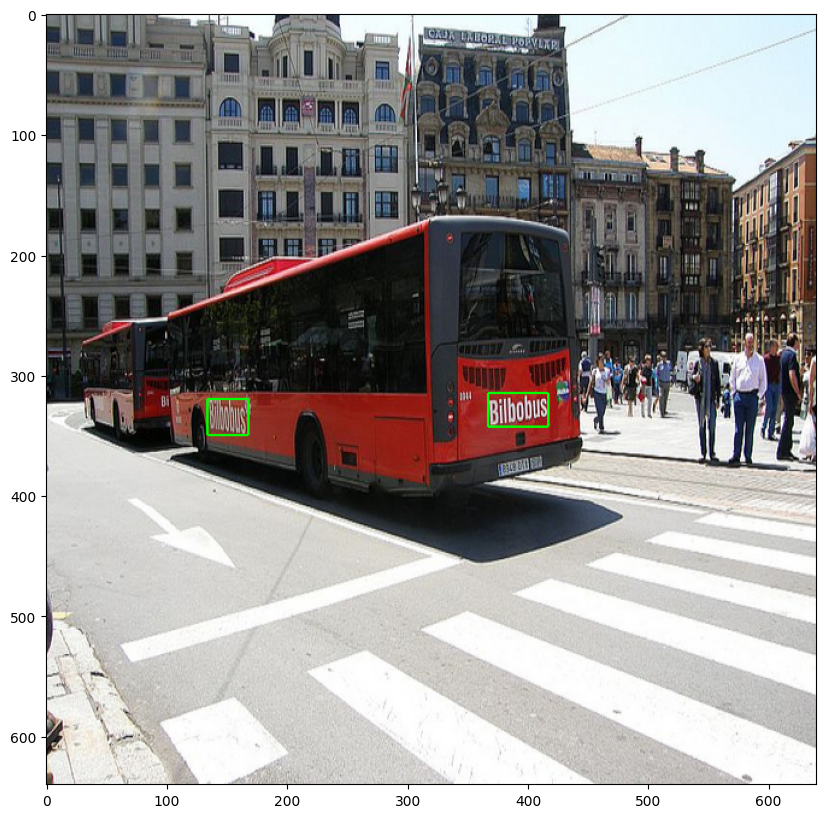

In [14]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [15]:
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [17]:
net = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=1, hw=160))#, l_size_lambda=3)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
net = train(ds_text, net=net, criterion=crit, batch_size=64, epochs=30, device=torch.device('cuda:3'), lr=1e-3)

epoch 0|0; total loss:76.5293960571289
last losses: [2294.3330078125, 0.23515573143959045, 1.3137534856796265]
epoch 0|30; total loss:36.5473518371582
last losses: [3.255699634552002, 0.3014763593673706, 0.736510694026947]
epoch 0|60; total loss:3.269817352294922
last losses: [2.0784740447998047, 0.27085787057876587, 0.6691113710403442]
epoch 0|90; total loss:2.825490951538086
last losses: [1.889290452003479, 0.25452181696891785, 0.6855414509773254]
epoch 0|120; total loss:2.6626346111297607
last losses: [1.77472984790802, 0.2603975832462311, 0.6060367822647095]
epoch 0|150; total loss:2.595228672027588
last losses: [1.5809756517410278, 0.25125086307525635, 0.7752718329429626]
epoch 0|180; total loss:2.4323034286499023
last losses: [1.5027683973312378, 0.2573345899581909, 0.6354851722717285]
epoch 0|210; total loss:2.3324248790740967
last losses: [1.596598505973816, 0.289615273475647, 0.5670700669288635]
epoch 0|240; total loss:2.2919843196868896
last losses: [1.3999933004379272, 0.260

epoch 7|30; total loss:1.0777783393859863
last losses: [0.5856517553329468, 0.21133020520210266, 0.2788504362106323]
epoch 7|60; total loss:1.0742592811584473
last losses: [0.5077393651008606, 0.16040122509002686, 0.16130389273166656]
epoch 7|90; total loss:1.0453603267669678
last losses: [0.6405380964279175, 0.21276088058948517, 0.21594958007335663]
epoch 7|120; total loss:1.0238378047943115
last losses: [0.577328085899353, 0.21781346201896667, 0.20364762842655182]
epoch 7|150; total loss:1.0579770803451538
last losses: [0.6321693062782288, 0.2173091620206833, 0.2008274793624878]
epoch 7|180; total loss:1.0916088819503784
last losses: [0.5944633483886719, 0.1998133510351181, 0.29451704025268555]
epoch 7|210; total loss:1.0559221506118774
last losses: [0.6565828323364258, 0.1891576200723648, 0.20579946041107178]
epoch 7|240; total loss:1.079399824142456
last losses: [0.5719793438911438, 0.18464404344558716, 0.18066062033176422]
epoch 7|270; total loss:1.038519263267517
last losses: [0.

epoch 14|0; total loss:0.018909187987446785
last losses: [0.29346963763237, 0.1519392728805542, 0.12186668068170547]
epoch 14|30; total loss:0.6578792929649353
last losses: [0.2980099320411682, 0.17716869711875916, 0.13600915670394897]
epoch 14|60; total loss:0.6172170042991638
last losses: [0.26294127106666565, 0.13865429162979126, 0.12327896058559418]
epoch 14|90; total loss:0.6295726299285889
last losses: [0.32848259806632996, 0.16131561994552612, 0.16952764987945557]
epoch 14|120; total loss:0.6207902431488037
last losses: [0.29935982823371887, 0.1676633208990097, 0.12869668006896973]
epoch 14|150; total loss:0.6526199579238892
last losses: [0.3134842813014984, 0.17893356084823608, 0.16150182485580444]
epoch 14|180; total loss:0.64146488904953
last losses: [0.2550881505012512, 0.1586330533027649, 0.10664106160402298]
epoch 14|210; total loss:0.6391766667366028
last losses: [0.38038164377212524, 0.20947934687137604, 0.18867938220500946]
epoch 14|240; total loss:0.659622073173523
las

epoch 20|270; total loss:0.5166580677032471
last losses: [0.18565374612808228, 0.14428488910198212, 0.10860496014356613]
epoch 21|0; total loss:0.015202646143734455
last losses: [0.18209822475910187, 0.1687944531440735, 0.10518670082092285]
epoch 21|30; total loss:0.4392850399017334
last losses: [0.13368383049964905, 0.15261828899383545, 0.11986954510211945]
epoch 21|60; total loss:0.4292769432067871
last losses: [0.12803080677986145, 0.14412228763103485, 0.0894467830657959]
epoch 21|90; total loss:0.4400191009044647
last losses: [0.16361306607723236, 0.13249334692955017, 0.09839345514774323]
epoch 21|120; total loss:0.44896069169044495
last losses: [0.1292918622493744, 0.13500434160232544, 0.0833544209599495]
epoch 21|150; total loss:0.44098401069641113
last losses: [0.19121038913726807, 0.17833442986011505, 0.127168208360672]
epoch 21|180; total loss:0.43279775977134705
last losses: [0.1917937844991684, 0.1616266667842865, 0.11328954994678497]
epoch 21|210; total loss:0.4445625841617

epoch 27|240; total loss:0.3641258776187897
last losses: [0.10395385324954987, 0.13511864840984344, 0.1156289353966713]
epoch 27|270; total loss:0.36789923906326294
last losses: [0.09686248004436493, 0.14043693244457245, 0.09806913137435913]
epoch 28|0; total loss:0.010656160302460194
last losses: [0.09152346849441528, 0.13388080894947052, 0.09428052604198456]
epoch 28|30; total loss:0.35048040747642517
last losses: [0.11747285723686218, 0.14973850548267365, 0.10715777426958084]
epoch 28|60; total loss:0.34671464562416077
last losses: [0.086912140250206, 0.15479649603366852, 0.09280942380428314]
epoch 28|90; total loss:0.3514522612094879
last losses: [0.10360495746135712, 0.14332692325115204, 0.11186564713716507]
epoch 28|120; total loss:0.3498438596725464
last losses: [0.08532188087701797, 0.13975819945335388, 0.08617015928030014]
epoch 28|150; total loss:0.34642595052719116
last losses: [0.09100539982318878, 0.15276211500167847, 0.09266318380832672]
epoch 28|180; total loss:0.3593071

In [19]:
torch.save(net, 'centernet.pth')

In [21]:
with torch.no_grad():
    yp_heat = net(x[None].to('cuda:3')).cpu()    
    yp = net(x[None].to('cuda:3'), return_objects=True).cpu()

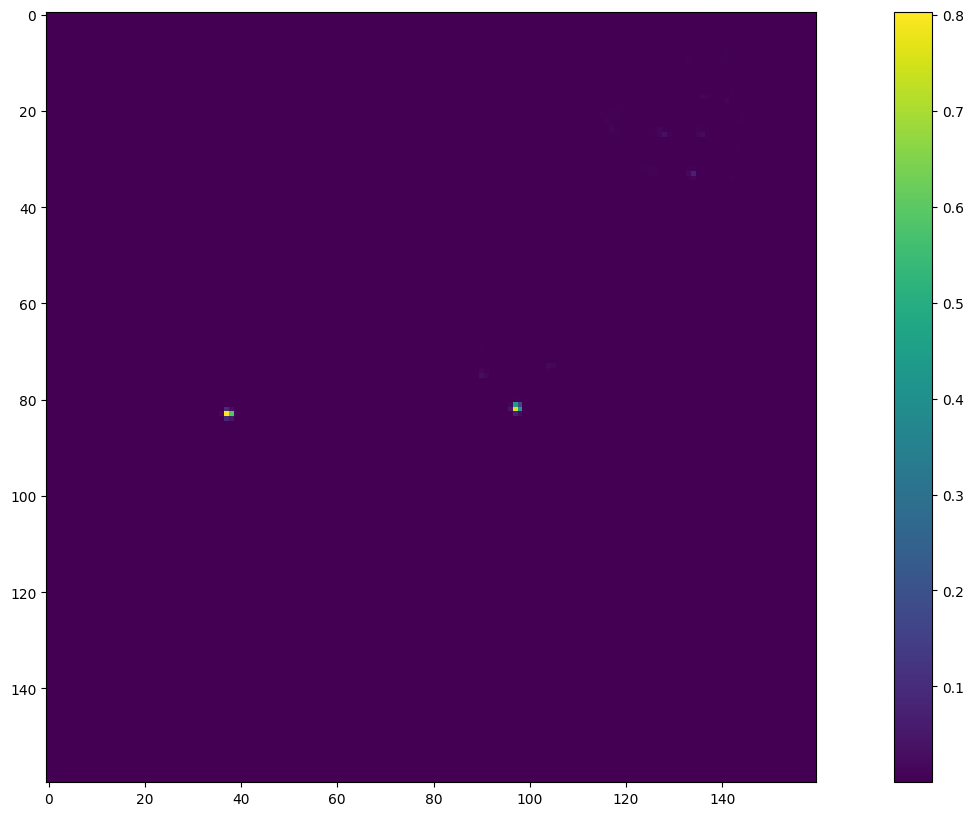

In [22]:
plt.imshow(yp_heat[0, 0])
plt.colorbar()

In [23]:
yp[0][:20]

tensor([[334.2833, 151.2415,  31.1429,  38.6770,   0.0000,   0.8029],
        [329.3455, 391.1550,  30.3521,  54.0735,   0.0000,   0.7590],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,  

In [24]:
y[:6]

tensor([[334.7333, 151.4000,  31.3333,  33.6000,   0.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


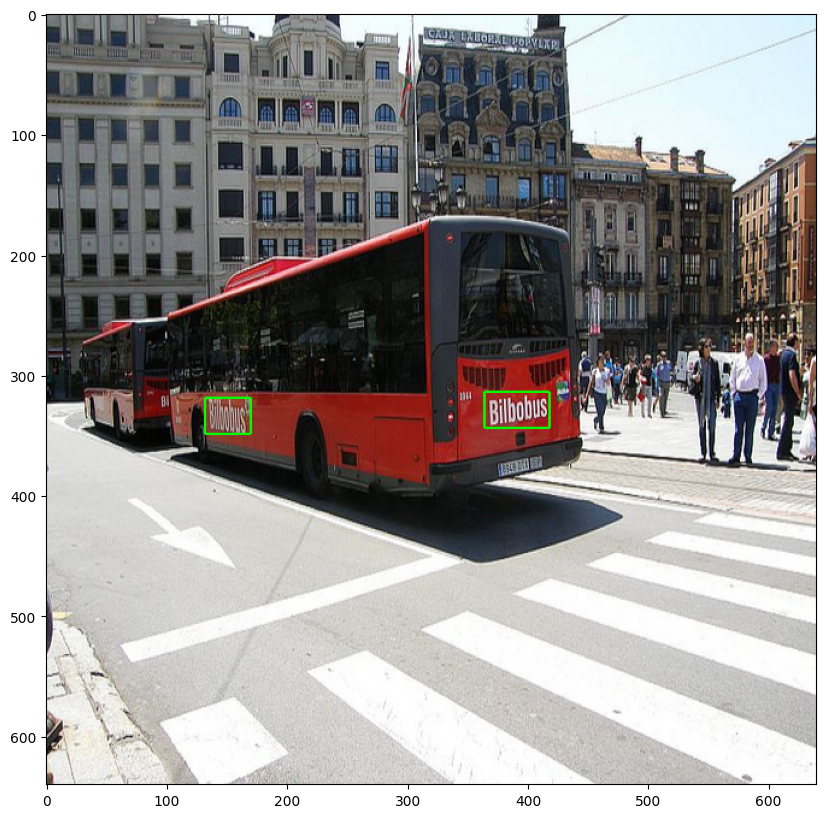

In [25]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
));